In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import math
import json
# import shap
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Pre-processing and Feature Engineering

### `portfolio` dataset

In [3]:
portfolio_channels = pd.get_dummies(pd.DataFrame(portfolio['channels'].values.tolist()).stack()).sum(level=0)
portfolio = pd.concat([portfolio.drop(['channels'], axis=1), portfolio_channels], axis=1 )
portfolio['offer_combo'] = (
    portfolio
    .filter(['offer_type', 'reward', 'difficulty', 'duration'])
    .astype(str)
    .agg('_'.join, axis=1)
)
portfolio 

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer_combo
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_10_7


### `profile` dataset

In [4]:
profile = (
    profile
    .assign(member_year=profile['became_member_on'].astype(str).str[:4].astype(int),
           member_month=profile['became_member_on'].astype(str).str[4:6].astype(int),
           member_date=profile['became_member_on'].astype(str).str[6:8].astype(int))
    .drop(['became_member_on'], axis=1)
)
profile.head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


In [5]:
profile[profile['gender'].isnull()].head()

,gender,age,id,income,member_year,member_month,member_date
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2


### `transcript` dataset

In [6]:
def process_transcript(event_type):
    val_text = 'offer ' + event_type
    time_col = 'offer_' + event_type + '_time'
    key = 'offer_id' if event_type == 'completed' else 'offer id'
    data = (
        transcript
        .query('event == @val_text')
        .assign(offer_id=lambda x: [d.get(key) for d in x['value']])
        .rename(columns={'time': time_col})
        .filter(['person', 'offer_id', time_col])
    )
    return data

def create_offer_count_features(data, event_type):
    old_col_name = 'offer_' + event_type + '_time'
    new_col_name = event_type + '_count'
    prefix = event_type + '_count_'
    grouped_data = (
        data
        .groupby(['person', 'offer_id'])
        .agg('count')
        .reset_index()
        .rename(columns={old_col_name: new_col_name})
        .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
        .filter(['person', 'offer_combo', new_col_name])
        .pivot(index='person', columns='offer_combo', values=new_col_name)
        .fillna(0)
        .assign(bogo_total=lambda x: x.filter(regex='bogo').sum(axis=1), 
               discount_total=lambda x: x.filter(regex='discount').sum(axis=1),
               informational_total=lambda x: x.filter(regex='informational').sum(axis=1),
               total=lambda x: x.filter(regex='total').sum(axis=1))
        .add_prefix(prefix)
        .reset_index()
    )
    
    return grouped_data

In [7]:
# those who received the offers 
offer_received = process_transcript('received')
received_ct_ids = create_offer_count_features(offer_received, 'received')
received_ct_ids.head()

offer_combo,person,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,received_count_bogo_5_5_7,received_count_discount_2_10_10,received_count_discount_2_10_7,received_count_discount_3_7_7,received_count_discount_5_20_10,received_count_informational_0_0_3,received_count_informational_0_0_4,received_count_bogo_total,received_count_discount_total,received_count_informational_total,received_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,5.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [8]:
# those who viewed the offers
offer_viewed = process_transcript('viewed')
viewed_ct_ids = create_offer_count_features(offer_viewed, 'viewed')
viewed_ct_ids.head()

offer_combo,person,viewed_count_bogo_10_10_5,viewed_count_bogo_10_10_7,viewed_count_bogo_5_5_5,viewed_count_bogo_5_5_7,viewed_count_discount_2_10_10,viewed_count_discount_2_10_7,viewed_count_discount_3_7_7,viewed_count_discount_5_20_10,viewed_count_informational_0_0_3,viewed_count_informational_0_0_4,viewed_count_bogo_total,viewed_count_discount_total,viewed_count_informational_total,viewed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,4.0


In [9]:
# those who completed the offers; note that this might include who didn't view, 
# thus didn't get affected by the offer
offer_completed = process_transcript('completed')
completed_ct_ids = create_offer_count_features(offer_completed, 'completed')
completed_ct_ids.head()

offer_combo,person,completed_count_bogo_10_10_5,completed_count_bogo_10_10_7,completed_count_bogo_5_5_5,completed_count_bogo_5_5_7,completed_count_discount_2_10_10,completed_count_discount_2_10_7,completed_count_discount_3_7_7,completed_count_discount_5_20_10,completed_count_bogo_total,completed_count_discount_total,completed_count_informational_total,completed_count_total
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,3.0
1,0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,3.0
2,0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0
4,003d66b6608740288d6cc97a6903f4f0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0


In [10]:
# those who made at least a transactions; note that this include both those 
# influenced and not influenced by promotional offers
transactions = (
    transcript
    .query('event == "transaction"')
    .assign(amount=lambda x: [d.get('amount') for d in x['value']])
    .rename(columns={'time': 'transaction_time'})
    .filter(['person', 'amount', 'transaction_time'])
    .sort_values(by=['person', 'transaction_time'])
    .assign(between_time=lambda x: x.groupby('person')['transaction_time'].transform(lambda x: x.diff()))
)

grouped_transactions = (
    transactions
    .groupby('person')
    .agg({'amount': ['count', 'sum', 'mean'], 'between_time': 'mean'})
    .reset_index()
    .droplevel(1, axis=1) 
)
grouped_transactions.columns = ['person', 'num_transactions', 'total_spent', 'mean_spent', 'mean_between_time']
grouped_transactions.head()

,person,num_transactions,total_spent,mean_spent,mean_between_time
0,0009655768c64bdeb2e877511632db8f,8,127.60,15.950000,66.857143
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,1.363333,90.000000
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,15.892000,130.500000
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,24.607500,93.428571
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,12.837500,57.272727


In [11]:
# those who completed the offers after viewing them and were eligible for rewards
completed_viewers = (
    offer_viewed
    .merge(offer_completed, how='left', on=['person', 'offer_id'])
    .query('offer_completed_time.notnull()', engine='python')
    .assign(completed_duration=lambda x: (x['offer_completed_time']-x['offer_viewed_time']) / 24)
    .merge(portfolio[['duration', 'id']], how='left', left_on='offer_id', right_on='id')
    .query('0 <= completed_duration <= duration')
    .merge(transactions[['person', 'transaction_time']], how='left', left_on=['person', 'offer_completed_time'], 
           right_on=['person', 'transaction_time'])
    .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
    .assign(mean_completed_by_offer=lambda x: x.groupby(['person', 'offer_id'])['completed_duration'].transform('mean'), 
            mean_completed_total=lambda x: x.groupby(['person'])['completed_duration'].transform('mean'))
    .filter(['person', 'offer_combo', 'mean_completed_by_offer', 'mean_completed_total'])
    .pivot_table(index=['person', 'mean_completed_total'], columns='offer_combo', 
                 values='mean_completed_by_offer', fill_value=0)
    .add_prefix('mean_completed_')
    .reset_index()
)
completed_viewers.head()

offer_combo,person,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,0011e0d4e6b944f998e987f904e8c1e5,3.750000,0.0,0.0,0.00,2.50,0.000000,0.0,2.75,6.0
1,0020c2b971eb4e9188eac86d93036a77,2.625000,3.5,0.0,0.00,0.00,1.750000,0.0,0.00,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,1.416667,0.0,0.0,1.25,0.75,0.000000,0.0,2.25,0.0
3,003d66b6608740288d6cc97a6903f4f0,5.166667,0.0,0.0,0.00,0.00,5.166667,0.0,0.00,0.0
4,00426fe3ffde4c6b9cb9ad6d077a13ea,3.000000,0.0,0.0,0.00,0.00,3.000000,0.0,0.00,0.0


### Final dataset for modeling

In [12]:
print('Checking that unique person IDs in newly created feature datasets exist in the raw `profile` data....')
print('################')
print('For `received_ct_ids`....')
print(len(set(received_ct_ids['person']).intersection(set(profile['id']))) == received_ct_ids['person'].nunique())
print('For `viewed_ct_ids`....')
print(len(set(viewed_ct_ids['person']).intersection(set(profile['id']))) == viewed_ct_ids['person'].nunique())
print('For `completed_ct_ids`....')
print(len(set(completed_ct_ids['person']).intersection(set(profile['id']))) == completed_ct_ids['person'].nunique())
print('For `grouped_transactions`....')
print(len(set(grouped_transactions['person']).intersection(set(profile['id']))) == grouped_transactions['person'].nunique())
print('For `completed_viewers`....')
print(len(set(completed_viewers['person']).intersection(set(profile['id']))) == completed_viewers['person'].nunique())

Checking that unique person IDs in newly created feature datasets exist in the raw `profile` data....
################
For `received_ct_ids`....
True
For `viewed_ct_ids`....
True
For `completed_ct_ids`....
True
For `grouped_transactions`....
True
For `completed_viewers`....
True


In [13]:
all_profiles = (
    profile
    .merge(received_ct_ids, how='left', left_on='id', right_on='person')
    .merge(viewed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(completed_ct_ids, how='left', left_on='id', right_on='person')
    .merge(grouped_transactions, how='left', left_on='id', right_on='person')
    .merge(completed_viewers, how='left', left_on='id', right_on='person')
)
all_profiles.drop(list(all_profiles.filter(regex='person')), axis=1, inplace=True)
cols_to_impute = [c for c in all_profiles.columns if c not in ['gender', 'income']]
all_profiles.update(all_profiles[cols_to_impute].fillna(0))
all_profiles.head()

,gender,age,id,income,member_year,member_month,member_date,received_count_bogo_10_10_5,received_count_bogo_10_10_7,received_count_bogo_5_5_5,...,mean_between_time,mean_completed_total,mean_completed_bogo_10_10_5,mean_completed_bogo_10_10_7,mean_completed_bogo_5_5_5,mean_completed_bogo_5_5_7,mean_completed_discount_2_10_10,mean_completed_discount_2_10_7,mean_completed_discount_3_7_7,mean_completed_discount_5_20_10
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,0.0,0.0,0.0,...,42.0,4.00,0.0,0.00,0.0,0.00,6.0,0.0,2.0,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,255.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,112.8,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,1.0,1.0,...,67.0,4.75,0.0,4.25,0.0,5.25,0.0,0.0,0.0,0.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,0.0,0.0,0.0,...,189.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


## Feature Analysis

In [14]:
def cut_age(value):
    if 18 <= value < 25:
        new = '18-24'
    elif 25 <= value < 35:
        new = '25-34'
    elif 35 <= value < 45:
        new = '35-44'
    elif 45 <= value < 55:
        new = '45-54'
    elif 55 <= value < 65:
        new = '55-64'
    elif 65 <= value < 75:
        new = '65-74'
    else:
        new = '75+'
    return new

def cut_income(value):
    if 30000 <= value < 35000:
        new = '30-35k'
    elif 35000 <= value < 50000:
        new = '35-50k'
    elif 50000 <= value < 75000:
        new = '50-75k'
    elif 75000 <= value < 100000:
        new = '75-100k'
    else:
        new = '100k+'
    return new

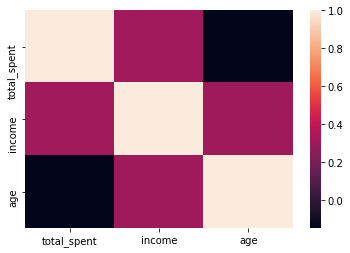

In [15]:
corr = all_profiles[['total_spent', 'income', 'age']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [16]:
main_profiles = all_profiles[all_profiles['gender'].notnull()]
unspecified_profiles = all_profiles[all_profiles['gender'].isnull()]

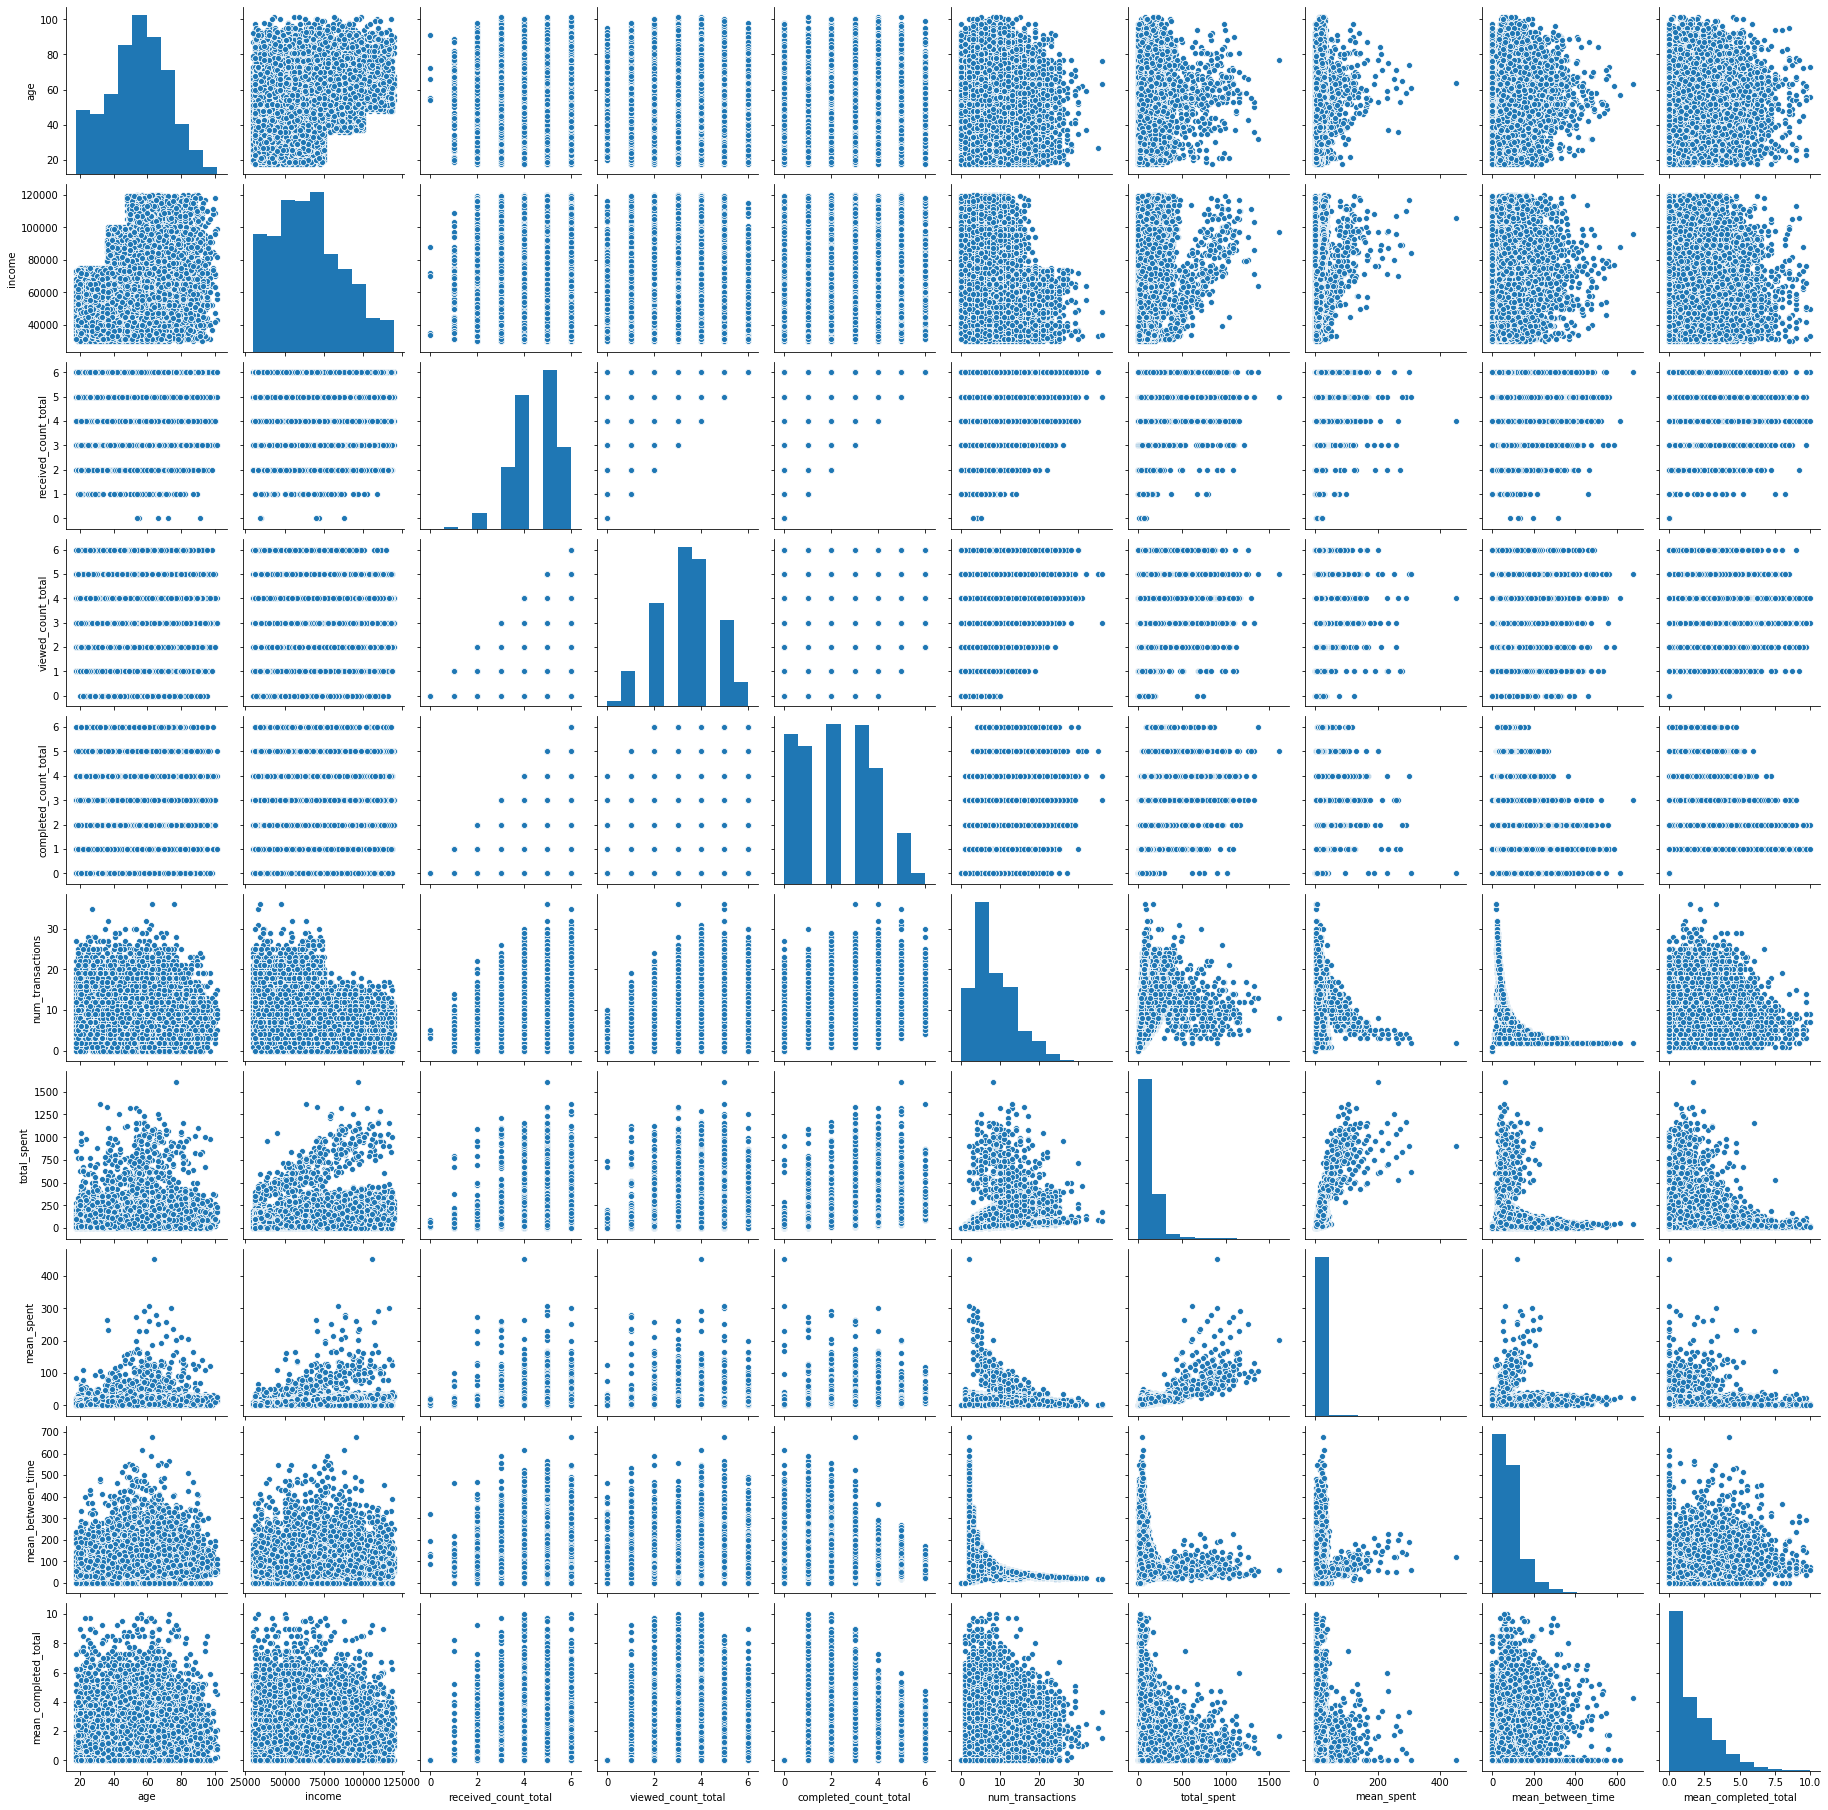

In [17]:
sns.pairplot(main_profiles[['age', 'income', 'received_count_total', 'viewed_count_total', 
                           'completed_count_total', 'num_transactions', 'total_spent',
                          'mean_spent', 'mean_between_time', 'mean_completed_total']])

In [18]:
all_profiles = (
    all_profiles    
    .assign(age_bin=lambda x: x['age'].apply(cut_age),
            income_bin=lambda x: x['income'].apply(cut_income))
)

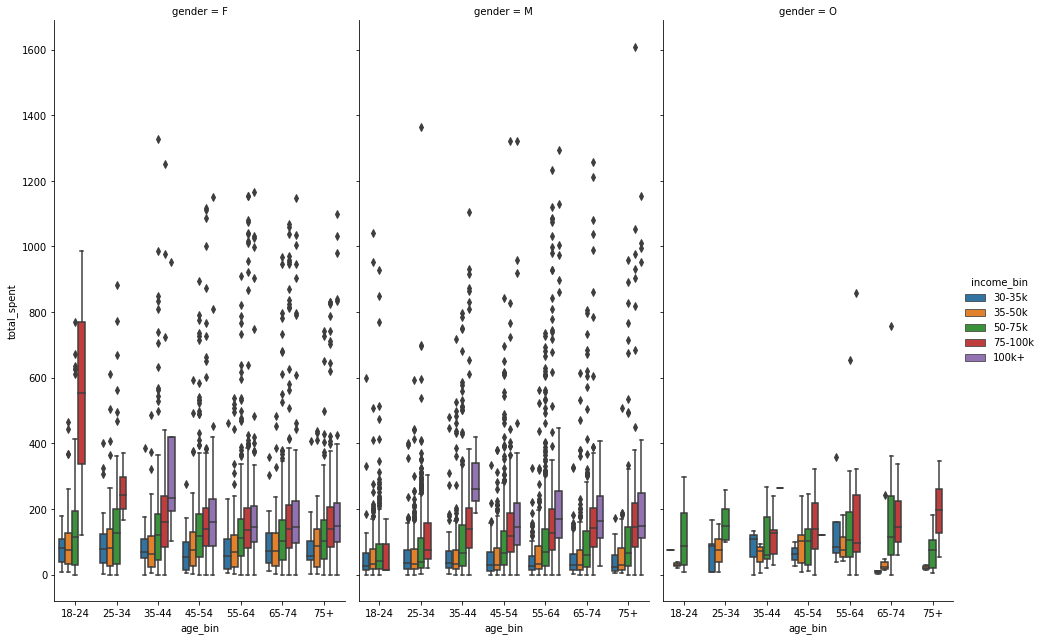

In [19]:
sns.catplot(x='age_bin', y='total_spent', hue ='income_bin', col='gender', kind='box',
            data=all_profiles.sort_values(['age_bin', 'income_bin']), height=9, aspect=0.5)

## Imputation 

### For `age` and `income`

In [20]:
main_profiles = (
    all_profiles
    .query('gender.notnull()', engine='python')
    .reset_index(drop=True)
)
unspecified_profiles = (
    all_profiles
    .query('gender.isnull()', engine='python')
    .reset_index(drop=True)
)

In [21]:
X = main_profiles.drop(['gender', 'age', 'id', 'income', 'age_bin', 'income_bin'], axis=1)
Y_num = main_profiles[['age', 'income']]
y_cat = main_profiles['gender']

X_to_impute = unspecified_profiles.drop(['gender', 'age', 'id', 'income', 'age_bin', 'income_bin'], axis=1)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_num, test_size=.2, random_state=42)

In [23]:
multi_rf_reg = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_rf_reg.fit(X_train, Y_train)
Y_pred = multi_rf_reg.predict(X_test)

In [24]:
print('R-squared score of random forest model to predict age:', 
      r2_score(Y_test.iloc[:, 0], Y_pred[:, 0]))
print('R-squared score of random forest model to predict income:', 
      r2_score(Y_test.iloc[:, 1], Y_pred[:, 1]))

R-squared score of random forest model to predict age: 0.08633744583683467
R-squared score of random forest model to predict income: 0.7086829106692178


In [25]:
multi_xb_reg = MultiOutputRegressor(xgb.XGBRegressor(random_state=42, learning_rate=0.01, 
                                                     n_estimators=500))
multi_xb_reg.fit(X_train, Y_train)
Y_pred = multi_xb_reg.predict(X_test)

In [26]:
print('R-squared score of XGBoost model to predict age:', 
      r2_score(Y_test.iloc[:, 0], Y_pred[:, 0]))
print('R-squared score of XGBoost model to predict income:', 
      r2_score(Y_test.iloc[:, 1], Y_pred[:, 1]))

R-squared score of XGBoost model to predict age: 0.10693430117082059
R-squared score of XGBoost model to predict income: 0.7180638618938058


In [27]:
imputed_y = multi_xb_reg.predict(X_to_impute)
unspecified_profiles['age'] = pd.Series(imputed_y[:, 0])
unspecified_profiles['income'] = pd.Series(imputed_y[:, 1])

### For `gender`

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=42)

In [29]:
y_train.value_counts()

M    6792
F    4904
O     164
Name: gender, dtype: int64

In [30]:
rf_cf = RandomForestClassifier(random_state=42)
rf_cf.fit(X_train, y_train)
y_pred = rf_cf.predict(X_test)

In [31]:
rf_cm = confusion_matrix(y_test, y_pred)

In [32]:
print('Confusion matrix for random forest model to predict gender: ', rf_cm)
print('Classification accuracy:', np.sum(np.diagonal(rf_cm)) / len(y_test) * 100)

Confusion matrix for random forest model to predict gender:  [[ 623  602    0]
 [ 503 1189    0]
 [  19   29    0]]
Classification accuracy: 61.11298482293424


In [33]:
xb_cf = xgb.XGBClassifier(random_state=42, learning_rate=0.01, n_estimators=500)
xb_cf.fit(X_train, y_train)
y_pred = xb_cf.predict(X_test)

In [34]:
xb_cm = confusion_matrix(y_test, y_pred)

In [35]:
print('Confusion matrix for XGBoost model to predict gender: ', xb_cm)
print('Classification accuracy:', np.sum(np.diagonal(xb_cm)) / len(y_test) * 100)

Confusion matrix for XGBoost model to predict gender:  [[ 662  561    2]
 [ 519 1173    0]
 [  20   28    0]]
Classification accuracy: 61.88870151770658


In [36]:
unspecified_profiles['gender'] = pd.Series(xb_cf.predict(X_to_impute))

In [37]:
imputed_all_profiles = pd.concat([main_profiles, unspecified_profiles])

In [38]:
imputed_all_profiles.isnull().mean()

gender                             0.0
age                                0.0
id                                 0.0
income                             0.0
member_year                        0.0
                                  ... 
mean_completed_discount_2_10_7     0.0
mean_completed_discount_3_7_7      0.0
mean_completed_discount_5_20_10    0.0
age_bin                            0.0
income_bin                         0.0
Length: 62, dtype: float64

## Feature Transformation

In [85]:
modeling_data = (
    imputed_all_profiles
    .drop(['id', 'age_bin', 'income_bin'], axis=1)
    .reset_index(drop=True)
)
modeling_data = pd.get_dummies(modeling_data, columns=['gender'], prefix_sep='_')

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(modeling_data)

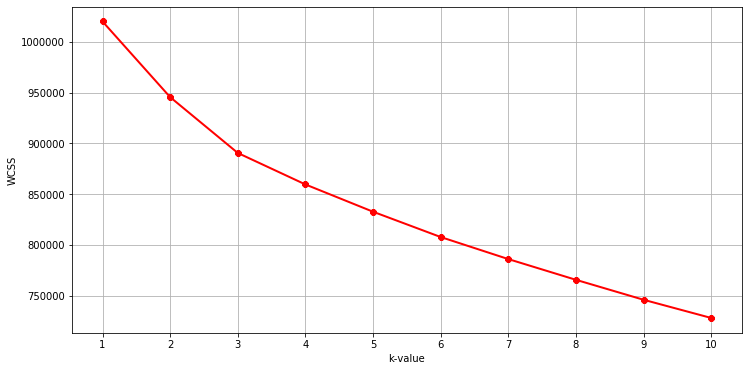

In [87]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1, 11),wcss, linewidth=2, color='red', marker ='8')
plt.xlabel('k-value')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('WCSS')
plt.show()

In [88]:
pca = PCA(.95)  # choose the minimum number of PC such that 95% of the variance is retained
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [89]:
print(pca.n_components_)
print(pca.explained_variance_)

32
[6.42207369 6.05990805 3.87287238 3.3918042  3.3189852  3.11615012
 2.96229    2.90466404 2.78888126 2.50977951 2.00786828 1.90449353
 1.49433048 1.42765449 1.16759111 1.08838344 1.01264831 0.99823579
 0.92072895 0.88886893 0.75474935 0.72666101 0.68952313 0.6831022
 0.64623648 0.59481869 0.59176239 0.57621533 0.55260609 0.49319313
 0.40978057 0.36884514]


## K-means clustering

In [90]:
pca_transformed = pca.transform(X)

In [93]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(pca_transformed)
pca_df = pd.DataFrame(pca_transformed)
pca_df['label'] = clusters
pca_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,-3.057115,-0.677372,-0.184090,-1.313416,-3.390842,0.933942,0.741480,1.847114,-2.543084,-2.773513,...,-0.535887,-0.105116,0.739191,-0.224640,-0.531593,0.711708,0.735759,0.646973,0.146946,2
1,-0.613449,5.700184,2.123267,-0.085153,-0.648892,1.033798,3.925361,2.141627,0.556257,-1.066847,...,3.587289,-0.770605,-0.688534,-0.997987,0.442995,1.705134,-0.309511,0.234746,0.593297,1
2,0.366123,-0.837734,-0.409748,1.296903,-1.987484,0.449142,0.647054,3.739212,2.054406,-0.736673,...,1.534449,-1.467770,-1.172203,-0.473696,1.106580,1.555649,0.260821,0.864857,-1.091495,2
3,3.216244,4.760046,-1.021261,1.761503,0.710490,5.623104,-1.963534,2.574923,5.696115,-0.376718,...,0.026188,3.839990,-0.921493,0.131653,0.822731,1.496476,-1.359848,0.044641,-0.392808,1
4,0.199735,-3.787691,-1.596772,1.947590,0.196026,-0.448247,0.516082,0.688340,-1.309392,-1.101769,...,-0.273698,-0.003003,-1.429343,0.012837,-1.267385,0.100128,0.206073,0.659560,-0.625514,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-0.620781,-1.437882,-1.372028,-1.037157,1.105917,2.038865,-0.935446,-0.746200,0.870674,0.274737,...,0.267441,-0.089373,0.271853,0.210413,-0.894240,0.659160,0.673231,-0.273547,-1.294324,2
16996,4.516943,-3.751446,-2.683935,1.902528,2.431383,-1.474314,1.094443,0.211702,0.668124,-1.198884,...,-0.513889,-0.853155,1.151114,0.901571,-0.089030,-1.325505,2.099615,0.020767,-1.652694,0
16997,-0.597476,-2.748838,-0.910427,-1.686706,2.695455,0.616522,-0.810670,-0.647559,1.708010,0.220045,...,0.270083,-0.354489,-0.418594,-0.357322,-1.481164,-0.009629,0.014098,-1.050988,-0.891170,2
16998,-4.295585,-1.465815,0.561919,0.029609,-0.368192,-0.297569,1.339343,-0.747638,-0.303721,-0.436359,...,-0.191592,-0.215565,0.874487,0.014803,-0.485971,0.664760,0.056553,-0.214171,0.117308,2


## Model analysis

In [96]:
final_data = pd.concat([pca_df, modeling_data], axis=1)

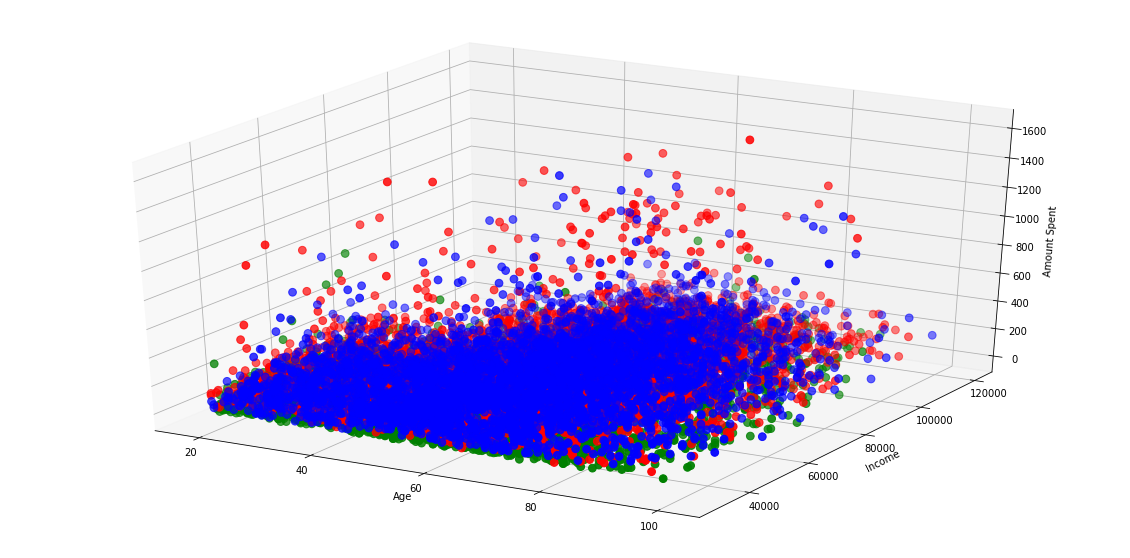

In [97]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_data[final_data['label'] == 0]['age'], 
           final_data[final_data['label'] == 0]['income'], 
           final_data[final_data['label'] == 0]['total_spent'], 
           c='blue', s=60)
ax.scatter(final_data[final_data['label'] == 1]['age'], 
           final_data[final_data['label'] == 1]['income'], 
           final_data[final_data['label'] == 1]['total_spent'], 
           c='red', s=60)
ax.scatter(final_data[final_data['label'] == 2]['age'], 
           final_data[final_data['label'] == 2]['income'], 
           final_data[final_data['label'] == 2]['total_spent'], 
           c='green', s=60)
plt.xlabel('Age')
plt.ylabel('Income')
ax.set_zlabel('Amount Spent')
plt.show()